# Sudoku Board Detection and Visualization

This notebook demonstrates how to use the Sudoku board detection module to extract boards from images and visualize the results.

In [3]:
# Import necessary packages
import os
import sys
import cv2
import matplotlib.pyplot as plt

# Add the src directory to the path so we can import our modules
sys.path.append('..')

# Import our modules
from src.processing.board_detection import BoardExtractor
from src.processing.data_processor import SudokuDataset
from src.utils import plot_grid, display_cell_grid

In [2]:
# Setup paths
from src.utils import setup_project_paths

paths = setup_project_paths()
print("Project paths:")
for key, path in paths.items():
    print(f"- {key}: {path}")

Project paths:
- project_root: /Users/matt/development/sudoku-ai
- data_dir: /Users/matt/development/sudoku-ai/data
- models_dir: /Users/matt/development/sudoku-ai/models
- notebooks_dir: /Users/matt/development/sudoku-ai/notebooks


## Load Dataset

We'll load a dataset containing Sudoku puzzle images. If you don't have one, you can generate one using the generator module.

In [ ]:
# Load a dataset
dataset = SudokuDataset()

# If you have a dataset zip file
dataset_name = 'mini_sudoku_dataset'  # Change to your dataset name
if os.path.exists(os.path.join(paths['data_dir'], f'{dataset_name}.zip')):
    dataset.load_dataset(dataset_name)
else:
    # If you don't have a dataset, generate one
    from generation.dataset_generator import generate_sample_dataset
    generator, samples = generate_sample_dataset(num_samples=10)
    dataset_name = os.path.basename(generator.output_dir)
    dataset.load_dataset(dataset_name)

Successfully extracted contents of '/Users/matt/development/sudoku-ai/data/mini_sudoku_dataset.zip' to '/Users/matt/development/sudoku-ai/data/extracted'
Dataset size: 30


In [4]:
# Print dataset info
dataset.print_dataset_info(detailed=True)

Dataset size: 30
Config: {'modes': ['printed', 'mixed'], 'difficulties': ['easy', 'medium', 'hard'], 'background_styles': ['none', 'unified'], 'mask_rates': [0.1, 0.3, 0.5, 0.7]}
Example: {'id': 'd1630174', 'label': 'M3M_d1630174', 'mode': 'mixed', 'difficulty': 'hard', 'background_style': 'unified', 'mask_rate': 0.7, 'grid': [[0, 0, 0, 0, 0, 8, 0, 0, 0], [0, 0, 0, 9, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 5, 0], [0, 0, 0, 0, 0, 0, 0, 0, 5], [0, 9, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 5, 0, 0, 1, 0, 0], [0, 0, 6, 3, 0, 7, 0, 0, 0], [0, 5, 0, 0, 0, 0, 9, 0, 0], [0, 0, 0, 0, 0, 9, 0, 0, 0]], 'solution': [[5, 4, 3, 7, 6, 8, 2, 9, 1], [6, 2, 7, 9, 1, 5, 8, 3, 4], [1, 8, 9, 4, 3, 2, 7, 5, 6], [7, 3, 1, 2, 9, 4, 6, 8, 5], [8, 9, 5, 6, 7, 1, 3, 4, 2], [4, 6, 2, 5, 8, 3, 1, 7, 9], [9, 1, 6, 3, 5, 7, 4, 2, 8], [3, 5, 4, 8, 2, 6, 9, 1, 7], [2, 7, 8, 1, 4, 9, 5, 6, 3]], 'handwritten_mask': [[0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1

## Load Samples and Visualize

Now we'll load some samples and visualize them.

Loading samples: 100%|██████████| 5/5 [00:00<00:00, 87.67it/s]


Loaded 5 samples


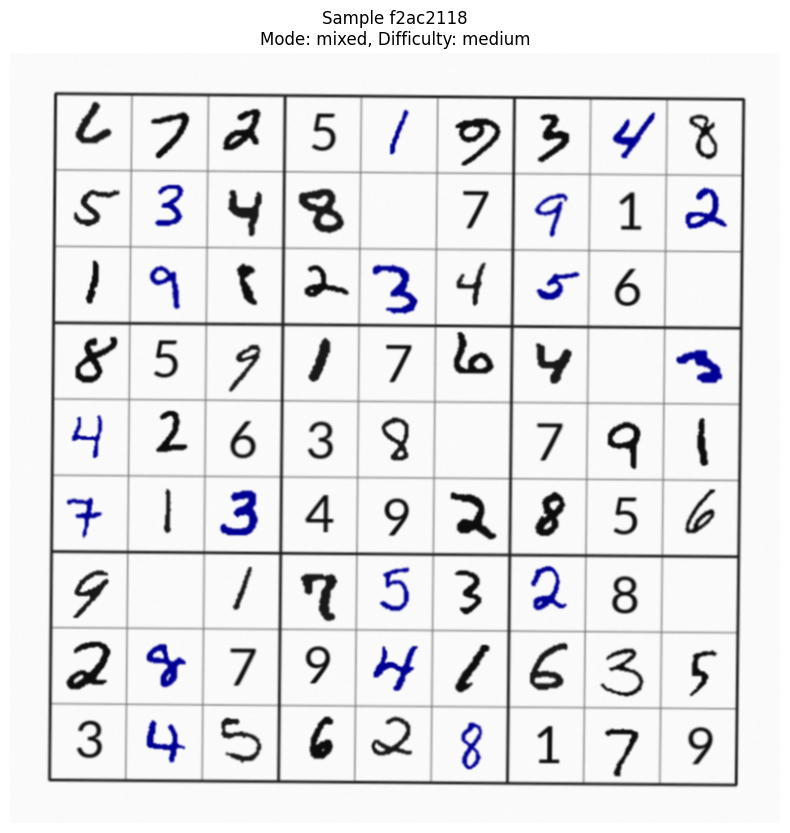

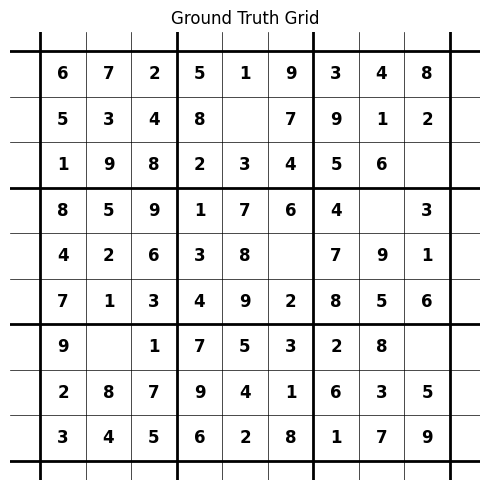

In [5]:
# Load a few samples
samples = dataset.load_samples(max_samples=5)

# Display the first sample
plt.figure(figsize=(10, 10))
plt.imshow(samples[0]['image'])
plt.title(f"Sample {samples[0]['id']}\nMode: {samples[0]['mode']}, Difficulty: {samples[0]['difficulty']}")
plt.axis('off')
plt.show()

# Display the ground truth grid
plot_grid(samples[0]['grid'], title="Ground Truth Grid")

## Board Extraction

Let's extract the board and cells from an image.

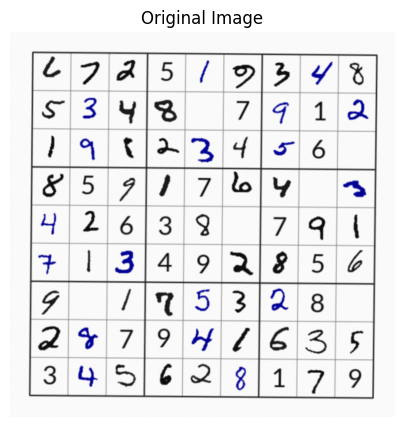

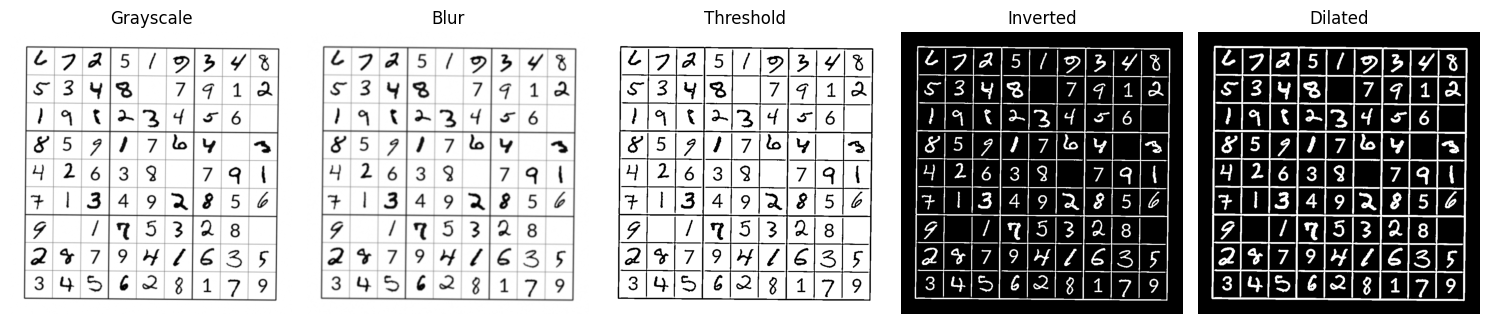

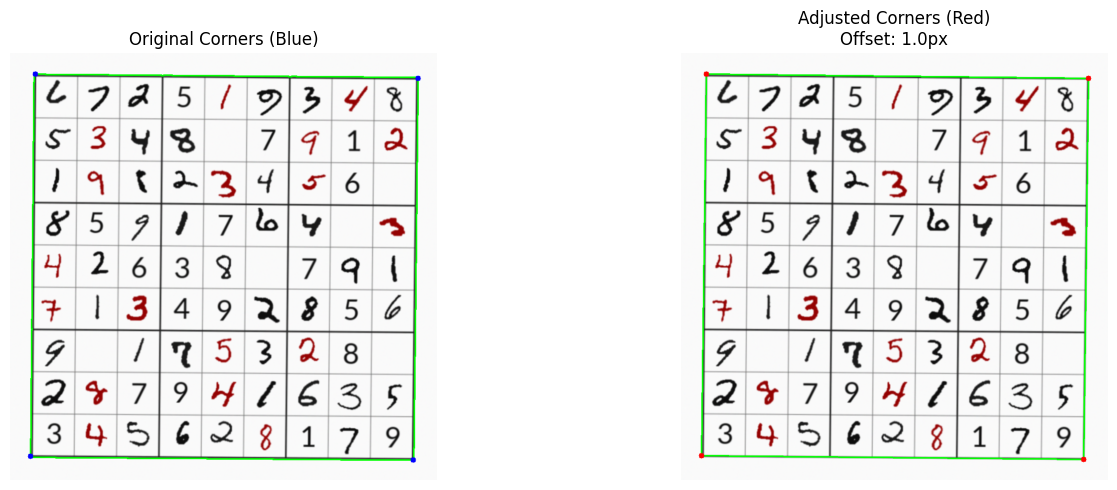

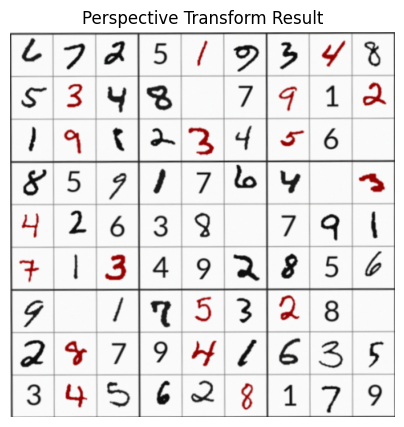

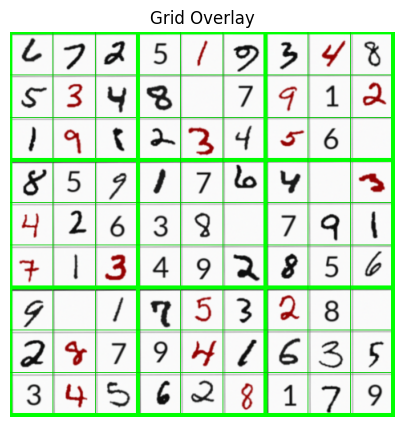

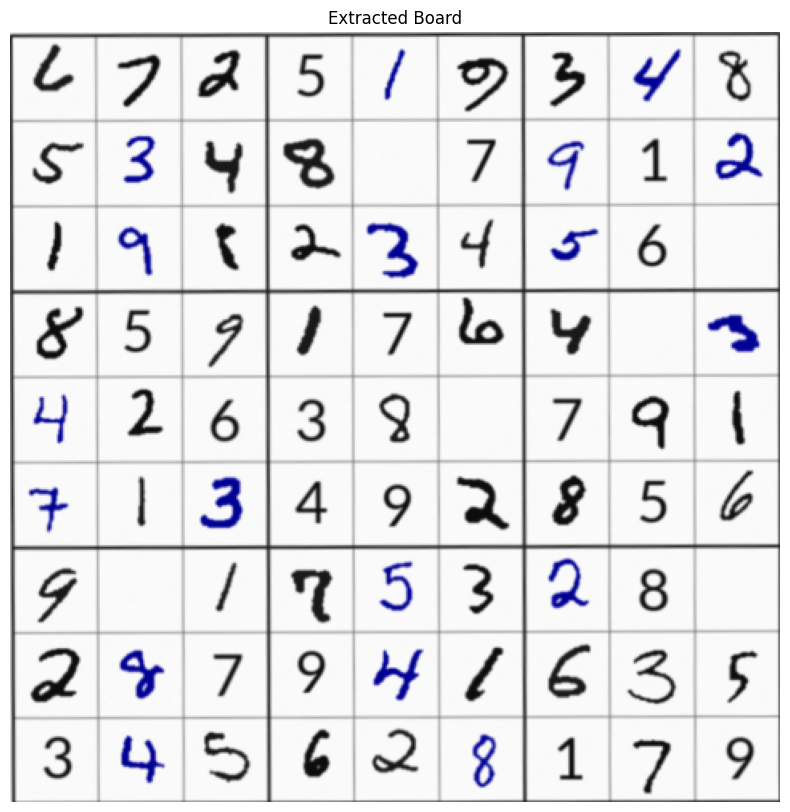

In [6]:
# Initialize the board extractor
extractor = BoardExtractor()

# Extract the board and cells from the first sample
sample = samples[0]
warped, cells = extractor.extract_board(sample['image'], display_steps=True)

# Display the extracted board
if warped is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(warped)
    plt.title("Extracted Board")
    plt.axis('off')
    plt.show()
else:
    print("Board extraction failed!")

## Cell Extraction

Now let's visualize the extracted cells.

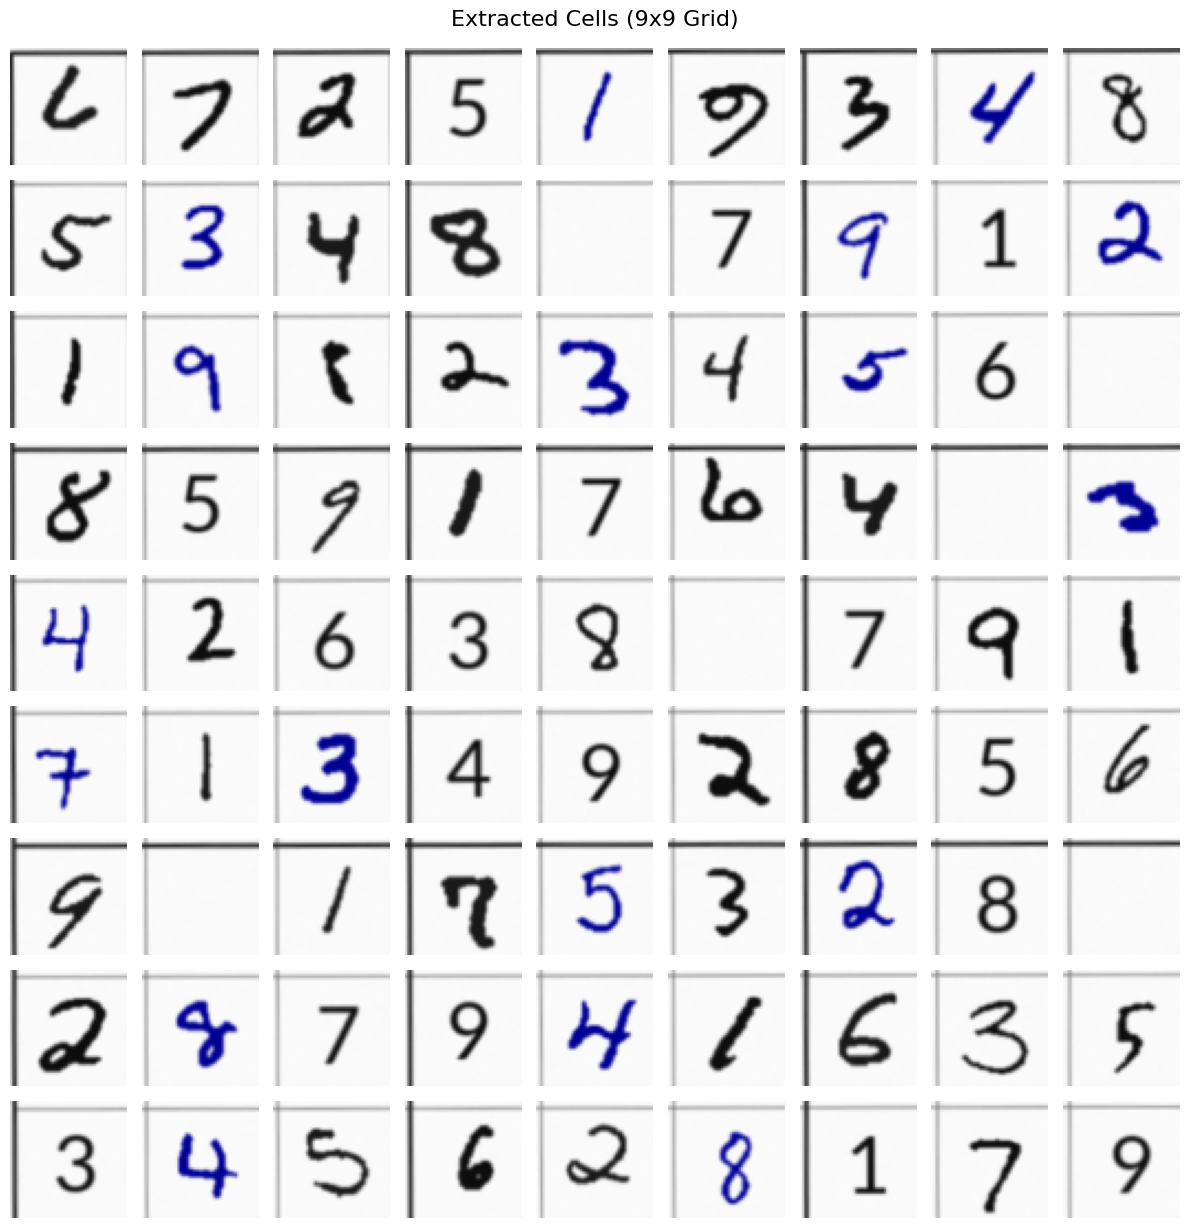

In [7]:
# Display the extracted cells if successful
if cells is not None:
    display_cell_grid(cells)
else:
    print("Cell extraction failed!")

## Process Multiple Images

Let's process multiple images and evaluate success rate.

In [8]:
# Process all samples
results = []
for sample in samples:
    warped, cells = extractor.extract_board(sample['image'], display_steps=False)
    results.append((warped is not None, cells is not None))

# Calculate success rate
board_success = sum(1 for board, _ in results if board) / len(results)
cell_success = sum(1 for _, cells in results if cells) / len(results)

print(f"Board extraction success rate: {board_success:.2%} ({sum(1 for board, _ in results if board)}/{len(results)})")
print(f"Cell extraction success rate: {cell_success:.2%} ({sum(1 for _, cells in results if cells)}/{len(results)})")

Board extraction success rate: 100.00% (5/5)
Cell extraction success rate: 100.00% (5/5)


## Try a Custom Image

You can also try the extraction on a custom image.

In [9]:
def process_custom_image(image_path):
    """Process a custom image and display the results."""
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image from {image_path}")
        return
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the original image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Custom Image")
    plt.axis('off')
    plt.show()
    
    # Extract the board and cells
    warped, cells = extractor.extract_board(image, display_steps=True)
    
    # Display the extracted board
    if warped is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(warped)
        plt.title("Extracted Board")
        plt.axis('off')
        plt.show()
    else:
        print("Board extraction failed!")
    
    # Display the extracted cells
    if cells is not None:
        display_cell_grid(cells)
    else:
        print("Cell extraction failed!")

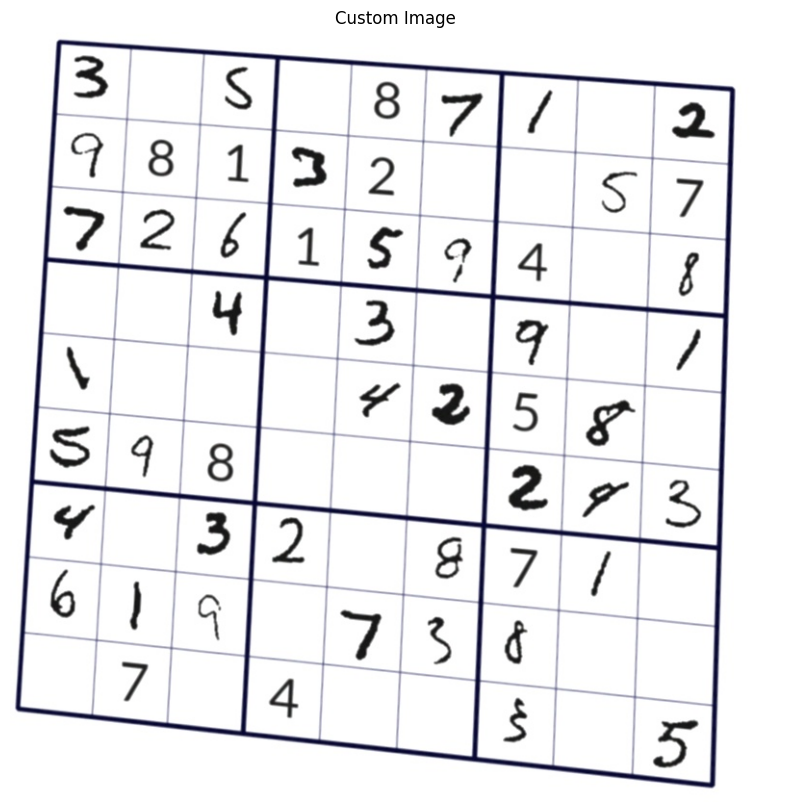

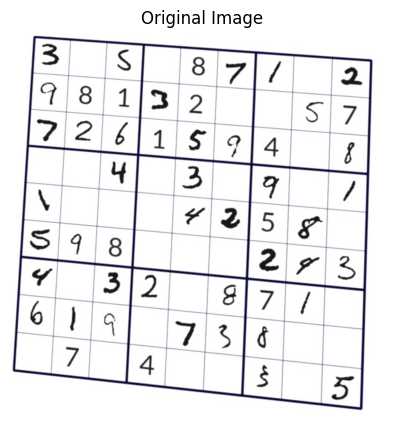

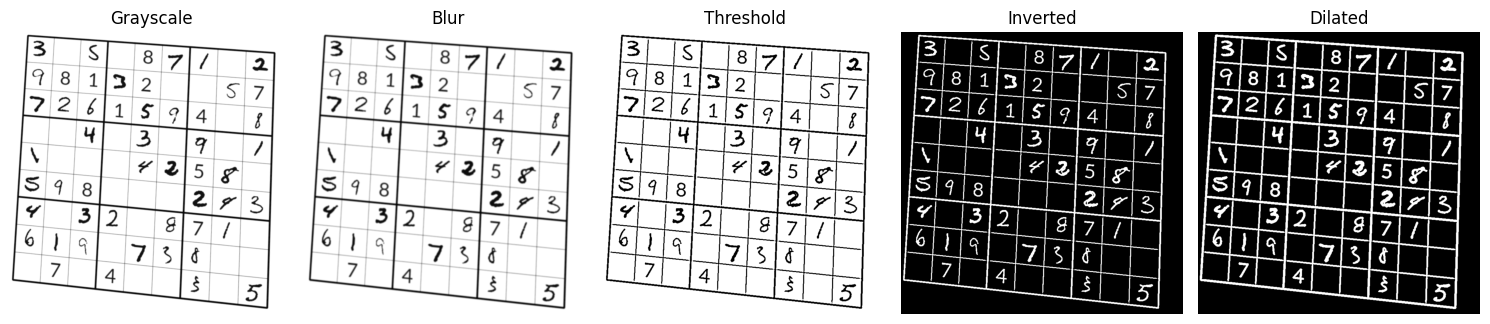

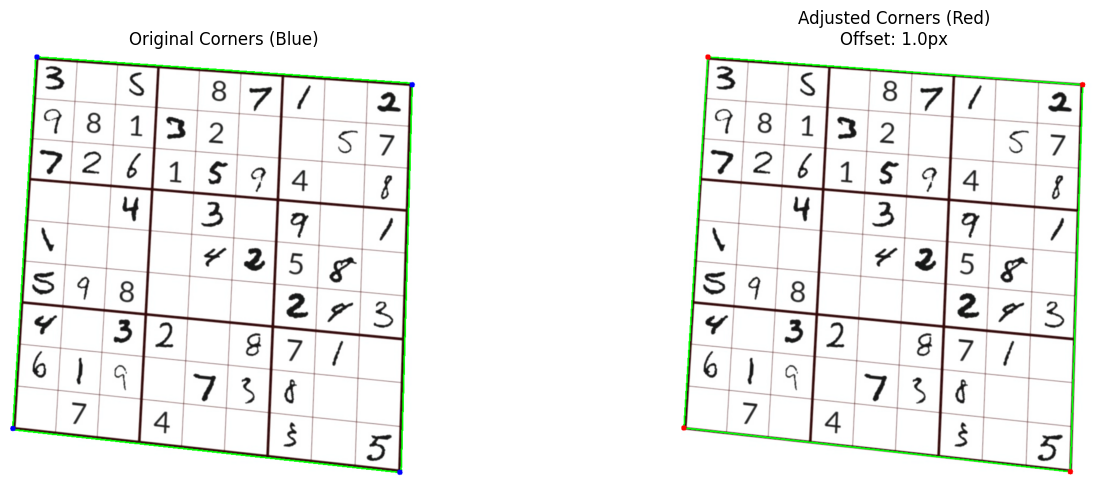

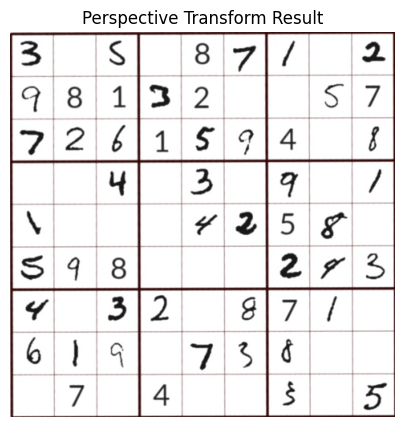

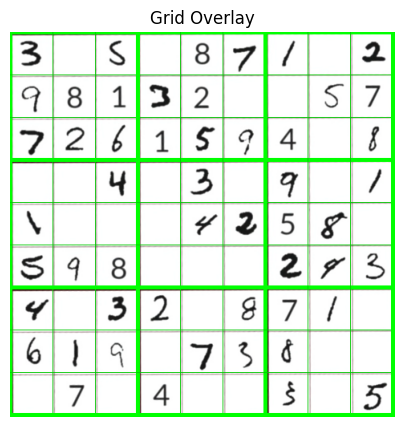

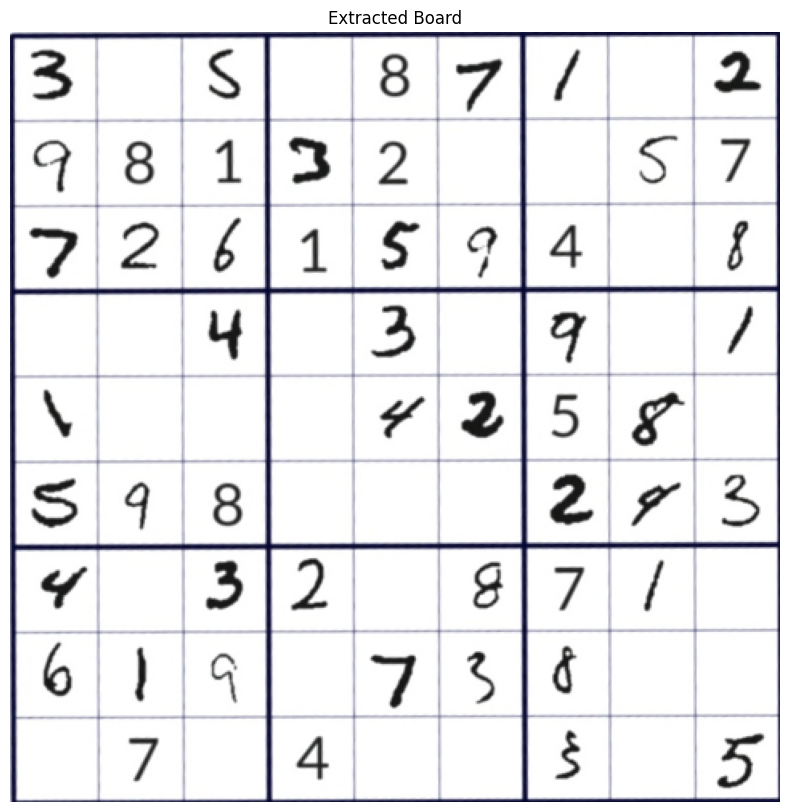

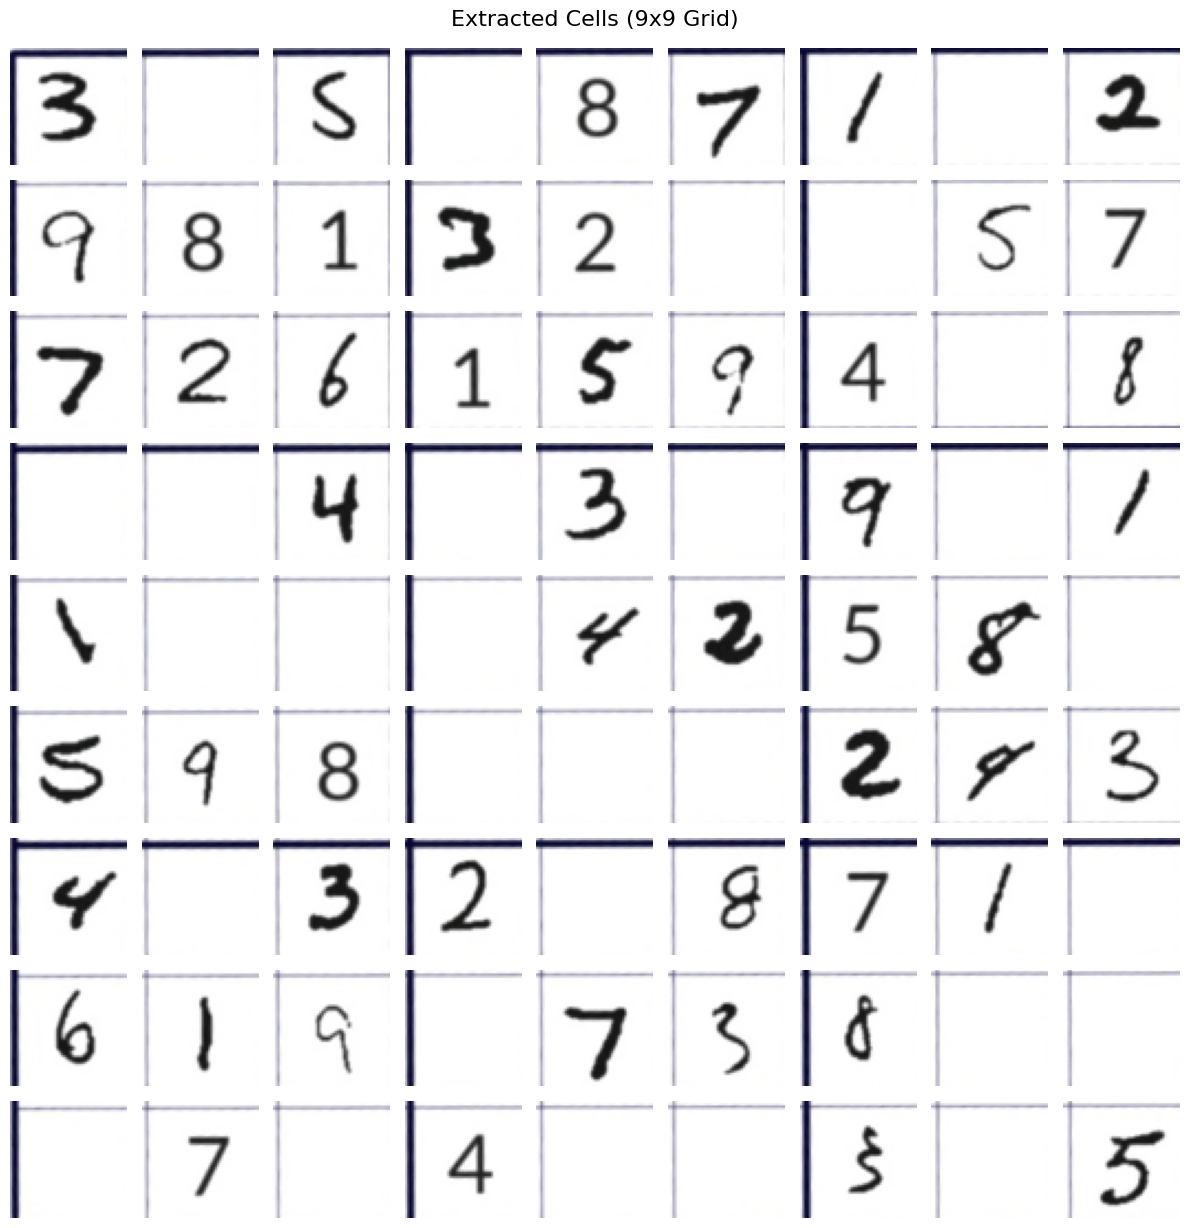

In [10]:
# Example: Using a custom image 
# custom_image_path = "/path/to/your/custom/sudoku/image.jpg"
# process_custom_image(custom_image_path)

# For now, let's use one of our samples again
# Save the image to disk first
custom_sample = samples[-1]
custom_path = os.path.join(paths['data_dir'], 'temp_custom.jpg')
cv2.imwrite(custom_path, cv2.cvtColor(custom_sample['image'], cv2.COLOR_RGB2BGR))

# Process it as a "custom" image
process_custom_image(custom_path)

## Conclusion

In this notebook, we've demonstrated how to extract Sudoku boards and cells from images using our `BoardExtractor` class. This is the first step in our Sudoku AI pipeline - after extracting the cells, we would typically run them through our digit recognition model to solve the puzzle.